# Places Classification

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt




C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow_model_optimization-0.7.4-py2.py3-none-any.whl (240 kB)
  Attempting uninstall: tensorflow-model-optimization
    Found existing installation: tensorflow-model-optimization 0.7.3
    Uninstalling tensorflow-model-optimization-0.7.3:
      Successfully uninstalled tensorflow-model-optimization-0.7.3



[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Set all the Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../../PlantVillage (copy)"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

# Import data into tensorflow dataset object

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 868 files belonging to 4 classes.


In [8]:
class_names = dataset.class_names
class_names

['Normal', 'miner', 'phoma', 'rust']

In [9]:
len(dataset)

28

# detect some of the images from our dataset

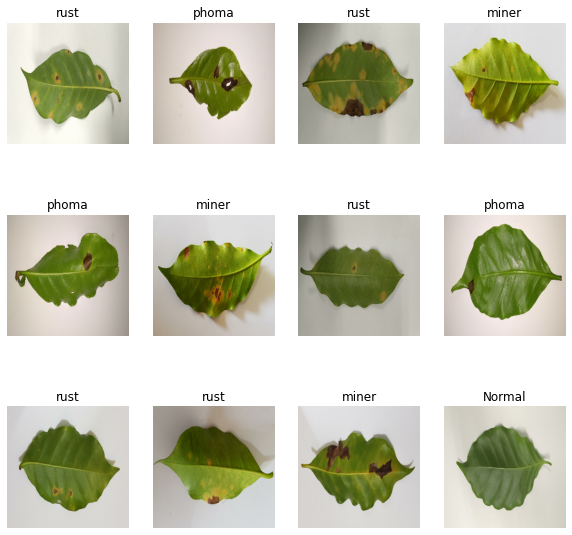

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset

### Dataset should be bifurcated into 3 subsets, namely:

    1.Training: Dataset to be used while training
    2.Validation: Dataset to be tested against while training
    3.Test: Dataset to be tested against after we trained a model

In [11]:
train_size = 0.8
len(dataset)*train_size

22.400000000000002

In [12]:
train_ds = dataset.take(66)
len(train_ds)

28

In [13]:
test_ds = dataset.skip(66)
len(test_ds)

0

In [14]:
val_size=0.1
len(dataset)*val_size

2.8000000000000003

In [15]:
val_ds = test_ds.take(8)
len(val_ds)

0

In [16]:
test_ds = test_ds.skip(8)
len(test_ds)

0

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

22

In [20]:
len(val_ds)

2

In [21]:
len(test_ds)

4

# Cache, Shuffle, and Prefetch the Dataset

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

##### We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=1,
)

22/22 [==============================] - 91s 4s/step - loss: 1.2163 - accuracy: 0.4083 - val_loss: 1.1179 - val_accuracy: 0.3594


In [42]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 5s 1s/step - loss: 1.1857 - accuracy: 0.3281


In [43]:
scores

[1.1856671571731567, 0.328125]

In [44]:
history

In [45]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 22}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
type(history.history['loss'])

list

In [48]:
len(history.history['loss'])

1

In [49]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.2162728309631348]

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [55]:
import matplotlib.pyplot as plt

# train the model
history = model.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val))

# plot training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




ValueError: in user code:

    File "C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "resizing" (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(32, 784), dtype=float32)


first image to predict
actual label: miner
predicted label: rust


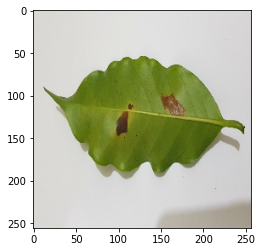

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

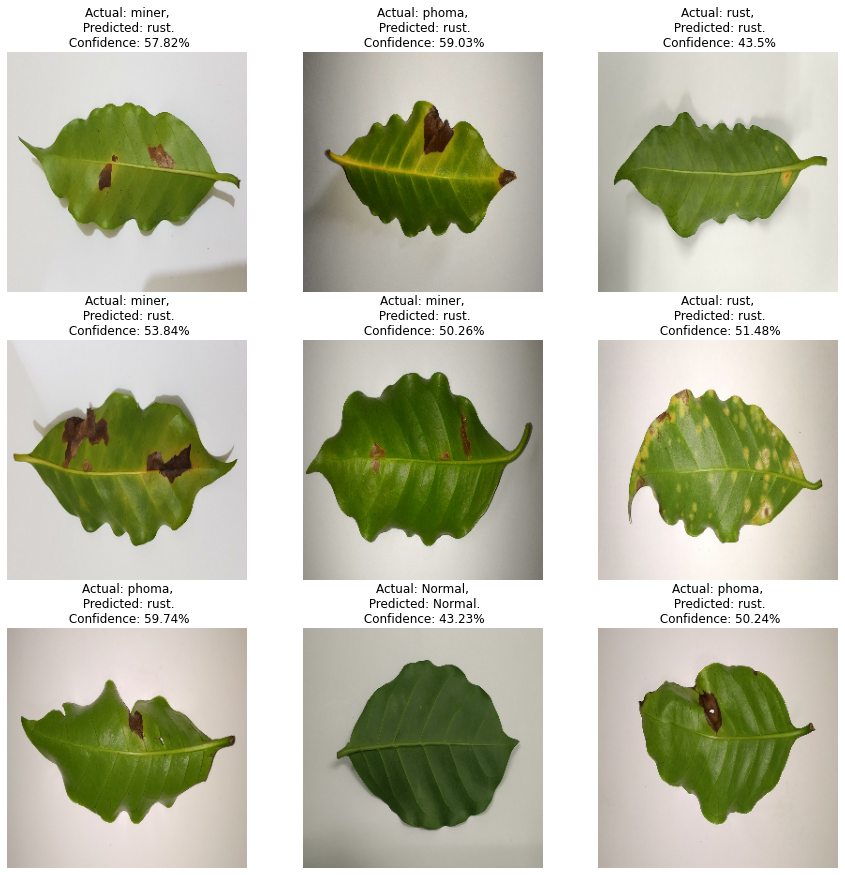

In [59]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the Network

In [61]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

22/22 [==============================] - 38s 2s/step - loss: 1.1279 - accuracy: 0.5178 - val_loss: 0.9231 - val_accuracy: 0.5469


# Testing the Model

In [62]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
4/4 [==============================] - 1s 354ms/step - loss: 0.9229 - accuracy: 0.6016
Test Accuracy: 60.160000000000004%


# Create a Quantization Aware Model

https://www.tensorflow.org/model_optimization/guide/quantization/training_example

# Quantize only the Dense, MaxPool2D, Conv2D Layers


In [63]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

# Clone the Model and Make Quantization Aware

In [64]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 254, 254, 32)     963       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 127, 127, 32)     1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 125, 125, 64)     18627     
 pperV2)                                                         
                                                                 
 quant_max_pooling2d_1 (Quan  (None, 62, 62, 64)       1         
 tizeWrapperV2)                                       

# Compile Quantization Aware Model before Fine Tuning

In [65]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Fine Tuning the Quantization Aware Model

In [66]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
22/22 [==============================] - 48s 2s/step - loss: 0.9590 - accuracy: 0.5695 - val_loss: 0.8399 - val_accuracy: 0.6406
Epoch 2/10
22/22 [==============================] - 46s 2s/step - loss: 0.8739 - accuracy: 0.6391 - val_loss: 0.7770 - val_accuracy: 0.7344
Epoch 3/10
22/22 [==============================] - 47s 2s/step - loss: 0.7958 - accuracy: 0.6716 - val_loss: 1.0907 - val_accuracy: 0.5625
Epoch 4/10
22/22 [==============================] - 47s 2s/step - loss: 0.7705 - accuracy: 0.6598 - val_loss: 0.7383 - val_accuracy: 0.6250
Epoch 5/10
22/22 [==============================] - 48s 2s/step - loss: 0.7098 - accuracy: 0.7352 - val_loss: 0.9509 - val_accuracy: 0.5938
Epoch 6/10
22/22 [==============================] - 49s 2s/step - loss: 0.7321 - accuracy: 0.7012 - val_loss: 0.6451 - val_accuracy: 0.7188
Epoch 7/10
22/22 [==============================] - 49s 2s/step - loss: 0.6445 - accuracy: 0.7441 - val_loss: 0.6346 - val_accuracy: 0.7188
Epoch 8/10
22/22 [==

# Evaluate the Model Accuracy

In [67]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
4/4 [==============================] - 3s 761ms/step - loss: 0.4613 - accuracy: 0.8125
Test Accuracy: 81.25%


# Convert Quanitzation Aware Model to TF Lite Model

### Convert the Model

In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Micheal\AppData\Local\Temp\tmp8rrmpl4_\assets


INFO:tensorflow:Assets written to: C:\Users\Micheal\AppData\Local\Temp\tmp8rrmpl4_\assets
C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


# Evaluate the TF Lite Model

In [ ]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

# Saving the TF Lite Model

### We append the model to the list of models as a new version

In [ ]:
import os
model_version = max([int(i) for i in (os.listdir("../tf-lite-models")+[0])]) + 1

with open(
    f"../tf-lite-models/{model_version}.tflite",
    'wb'
) as f:
    f.write(quantized_tflite_model)

# Plotting the Inference Data

In [61]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

NameError: name 'interpreter' is not defined

In [67]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/12\assets


INFO:tensorflow:Assets written to: ../models/12\assets


In [68]:
model.save("../detection.h5")

In [69]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

OSError: SavedModel file does not exist at: ./saved_model\{saved_model.pbtxt|saved_model.pb}

In [70]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

OSError: SavedModel file does not exist at: ./saved_model\{saved_model.pbtxt|saved_model.pb}

In [71]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

NameError: name 'tflite_qaware_model' is not defined

In [72]:
converter = tf.lite.TFLiteConverter.from_saved_model("../models/5")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [73]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [74]:
input_details

[{'name': 'serving_default_sequential_input:0',
  'index': 0,
  'shape': array([  1, 256, 256,   3]),
  'shape_signature': array([ -1, 256, 256,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [75]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 35,
  'shape': array([1, 8]),
  'shape_signature': array([-1,  8]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [76]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [77]:
test_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [78]:
count = 0
for image, label in test_ds.take(5):
    print(label)
    
print(count)

tf.Tensor([0 3 1 2 2 3 1 1 3 1 2 2 0 1 1 1 2 2 3 2 2 2 2 2 2 1 1 2 2 3 3 1], shape=(32,), dtype=int32)
tf.Tensor([1 3 3 2 1 3 3 2 1 2 1 0 3 3 3 3 2 2 1 1 2 2 1 2 2 2 0 1 3 1 2 3], shape=(32,), dtype=int32)
tf.Tensor([2 2 0 2 2 2 3 0 0 2 0 1 2 2 1 3 1 1 0 0 3 1 0 0 3 3 3 3 2 3 2 2], shape=(32,), dtype=int32)
tf.Tensor([3 2 3 1 1 2 1 2 1 3 2 0 3 2 3 3 1 2 3 1 3 2 0 2 2 1 3 1 1 0 3 3], shape=(32,), dtype=int32)
0


In [79]:
for image, label in test_ds.unbatch().take(5):
    print("image shape",image.shape)
    print("label",label)

image shape (256, 256, 3)
label tf.Tensor(2, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(2, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(0, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(2, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(2, shape=(), dtype=int32)


In [80]:
for image, label in test_ds.unbatch().take(5):
    interpreter.set_tensor(input_index, [image.numpy().astype(np.float32)])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)

NameError: name 'input_index' is not defined

In [81]:
predicted_labels = []
actual_labels = []

for image, label in test_ds.unbatch():
    interpreter.set_tensor(input_index, [image])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_labels.append(np.argmax(output[0]))
    actual_labels.append(label.numpy())

NameError: name 'input_index' is not defined

In [82]:
predicted_labels[:10]

[]

In [83]:
actual_labels[:10]

[]

In [84]:
comparison_vector = np.array(predicted_labels) == np.array(actual_labels)
comparison_vector[:10]

array([], dtype=bool)

In [85]:
np.array([True,False,True]).mean()

0.6666666666666666

In [86]:
accuracy = comparison_vector.mean()
accuracy

C:\Users\Micheal\AppData\Local\Temp\ipykernel_1596\392491970.py:1: RuntimeWarning: Mean of empty slice.
  accuracy = comparison_vector.mean()
C:\Users\Micheal\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  if is_float16_result:


nan

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=keras \
    model.h5 \
    /tmp/my_tfjs_model